## SSAC - Exploration 3 - Face detection with pre-trained model in dlib.

In [1]:
# import required packages
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

(192, 192, 3)


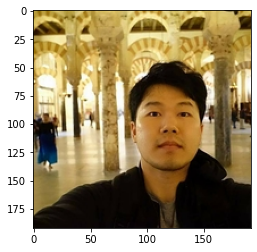

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/myimage_1.jpg'
img_bgr = cv2.imread(my_image_path)  # laod image
print(img_bgr.shape)
img_show = img_bgr.copy()      # set aside original for future use
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

+ Since my image size is small I'd proceed without resizing. 

### Face Detection

In [3]:
detector_hog = dlib.get_frontal_face_detector() # load dlib facedetector

In [4]:
dlib_rects = detector_hog(img_rgb, 1) # face detect in loaded image

In [5]:
print(dlib_rects) # face detect rectangle location index

rectangles[[(87, 73) (149, 135)]]


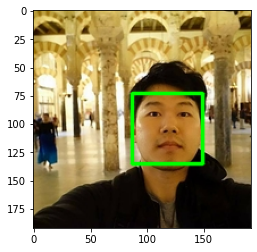

In [6]:
for f in dlib_rects:
    l = f.left()
    t = f.top()
    r = f.right()
    b = f.bottom()
    cv2.rectangle(img_show, (l,t),(r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # green color

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) 
plt.imshow(img_show_rgb)
plt.show()

In [7]:
# load pre-trained model
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
# gather landmarks location with loaded model
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


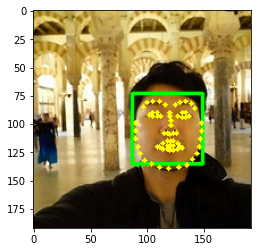

In [9]:
# place yellow dots at landmarks
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # green + blue = yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [10]:
# gather location value of landmarks
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose tip index : 33
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print ('(w,h) : (%d,%d)'%(w,h))

(120, 109)
(x,y) : (120,109)
(w,h) : (63,63)


+ index number of the tip of the nose is 33.
  + tip of the nose location : (120, 109)

In [11]:
# load and resize sticker image
new_png_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(new_png_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(63, 63, 3)


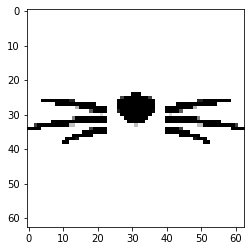

In [12]:
plt.imshow(img_sticker)
plt.show()

In [13]:
refined_x = x - w //2  # left
refined_y = y - w //2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (89,78)


+ nose is centered in sticker image.
   + as we starts from tip of the nose, left-top of sticker should be moved half length of sticker image size along each axis.

In [14]:
sticker_area = img_show_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show_rgb[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

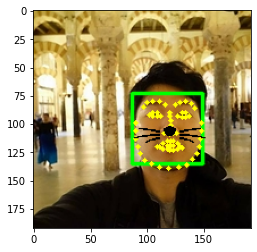

In [15]:
plt.imshow(img_show_rgb)
plt.show()

In [16]:
img_show = img_bgr.copy()

In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

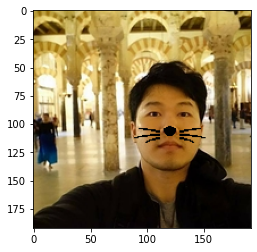

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### Make whiskers translucent

In [19]:
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
dst = cv2.addWeighted(img_rgb, 0.5, img_show_rgb, 0.5, 0)

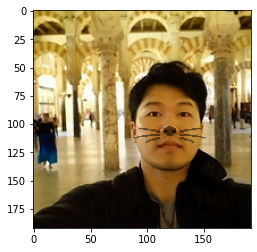

In [20]:
plt.imshow(dst)
plt.show()

### Attach whiskers to various pictures

In [21]:
# resize function
def sticker_img_resize(image, out_w=640, out_h=360):
    
    img_h, img_w, _ch = image.shape  # actual image size
    
    if img_h > img_w:          # vertical image
        h = max(out_w, out_h)    # take long side of target size as h
        w = min(out_w, out_h)
    if img_h < img_w:          # horizontal image
        h = min(out_w, out_h)
        w = max(out_w, out_h)    # take long side of traget size as w
    if img_h == img_w:         # square image
        same_l = int((out_w+out_h)/2)
        image = cv2.resize(image, (same_l, same_l))
        print(image.shape)
        return image

    target_ratio = w/h         # wanted size ratio
    input_ratio = img_w/img_h  # actual image size ratio

    if target_ratio > input_ratio:     # when input height value is larger than wanted
        dim = (w, int(w/input_ratio))  # calculate reduced image size maintaining original ratio
        image = cv2.resize(image, dim) # resize
        h1 = int((dim[1] - h)/2)       # determine crop point with assumption that face would locate in the middle of the picture
        h2 = h1 + h
        image = image[h1:h2, :, :]     # crop image

    elif target_ratio < input_ratio:   # when input width value is larger than wanted
        dim = (int(h*input_ratio), h)
        image = cv2.resize(image, dim)
        w1 = int((dim[0] - w)/2)
        w2 = w1 + w
        image = image[:, w1:w2, :]

    else:
        image = cv2.resize(image, (w,h)) # when input image ratio == wanted image ratio

    print(image.shape)
    return image 

In [22]:
# marking landmarks function
def mark_landmarks(image):
    detector_hog = dlib.get_frontal_face_detector()
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    img_mark = image.copy()
    
    dlib_rects = detector_hog(image)
   
    for f in dlib_rects:
        l = f.left()
        t = f.top()
        r = f.right()
        b = f.bottom()
        cv2.rectangle(img_mark, (l,t),(r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(image, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts())) # gather locaton of landmarks
        list_landmarks.append(list_points)    
        for landmark in list_landmarks:       # for landmarks of a detected face
            for idx, point in enumerate(list_points):
                cv2.circle(img_mark, point, 2, (0, 255, 255), -1)  # place yellow dots at landmarks
    
    image = cv2.cvtColor(img_mark, cv2.COLOR_BGR2RGB)
    return image

In [23]:
# cat whisker sticker function
def cat_whisker_sticker(image):

    detector_hog = dlib.get_frontal_face_detector()
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)

    img_org = image.copy()
    
    dlib_rects = detector_hog(image)

    print(f'number of faces : {len(dlib_rects)}')

    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(image, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    new_png_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(new_png_path)

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[33][0]
        y = landmark[33][1]
        w = dlib_rect.width()
        h = dlib_rect.width()

        img_sticker = cv2.resize(img_sticker, (w,h))

        refined_x = x - w //2  # left
        refined_y = y - w //2  # top

        sticker_area = img_org[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]  # assign area for whisker
        img_org[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

    dst = cv2.addWeighted(img_org, 0.6, image, 0.4, 0) # 0.6 * image with whisker + 0.4 * image without whisker
    image = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    return image

---

+ new image : horizontal image
  + image source : https://unsplash.com/photos/rDEOVtE7vOs

In [24]:
new_img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image_01.jpg'

(360, 640, 3)


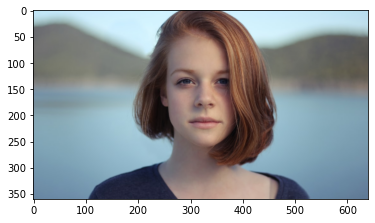

In [25]:
img_bgr = cv2.imread(new_img_path)
img = sticker_img_resize(img_bgr)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

number of faces : 1


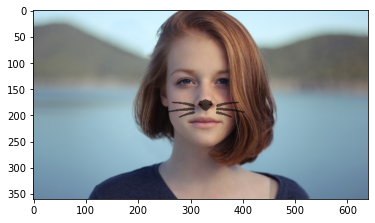

In [26]:
img_sticker = cat_whisker_sticker(img)
plt.imshow(img_sticker)
plt.show()

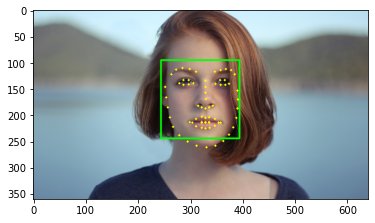

In [27]:
img_landmark = mark_landmarks(img)
plt.imshow(img_landmark)
plt.show()

---

+ new image : vertical image, beard man
  + image source : https://unsplash.com/photos/N2IJ31xZ_ks

In [28]:
new_img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image_02.jpg'

(640, 360, 3)


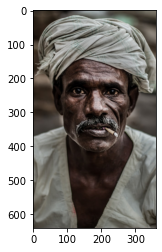

In [29]:
img_bgr = cv2.imread(new_img_path)
img = sticker_img_resize(img_bgr)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

number of faces : 1


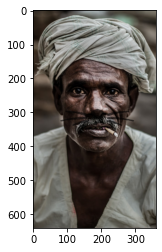

In [30]:
img_sticker = cat_whisker_sticker(img)
plt.imshow(img_sticker)
plt.show()

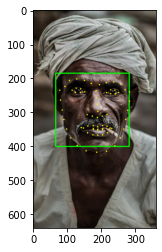

In [31]:
img_landmark = mark_landmarks(img)
plt.imshow(img_landmark)
plt.show()

+ works well with beard

---

+ new image : vertical image, with makeup
  + image source : https://unsplash.com/photos/GZMcqV9j7VE

In [32]:
new_img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image_03.jpg'

(640, 360, 3)


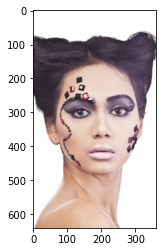

In [33]:
img_bgr = cv2.imread(new_img_path)
img = sticker_img_resize(img_bgr)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

number of faces : 1


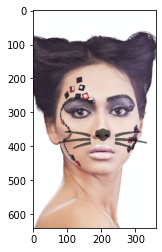

In [34]:
img_sticker = cat_whisker_sticker(img)
plt.imshow(img_sticker)
plt.show()

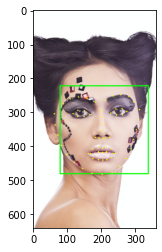

In [35]:
img_landmark = mark_landmarks(img)
plt.imshow(img_landmark)
plt.show()

+ works well with makeup

---

+ new image : vertical image, with sunglasses
  + image source : https://unsplash.com/photos/icu-D9rYM4w

In [36]:
new_img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image_04.jpg'

(640, 360, 3)


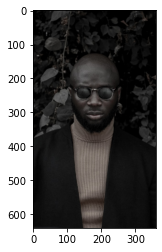

In [37]:
img_bgr = cv2.imread(new_img_path)
img = sticker_img_resize(img_bgr)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

number of faces : 1


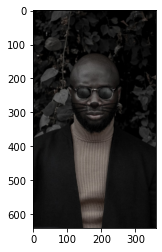

In [38]:
img_sticker = cat_whisker_sticker(img)
plt.imshow(img_sticker)
plt.show()

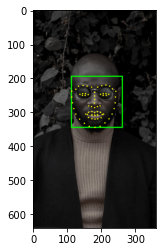

In [39]:
img_landmark = mark_landmarks(img)
plt.imshow(img_landmark)
plt.show()

+ works well with sunglasses
+ works well with dark image

---

+ gray scale with glasses
  + image source : https://unsplash.com/photos/l9I93gZKTG4

In [40]:
new_img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image_05.jpg'

(640, 360, 3)


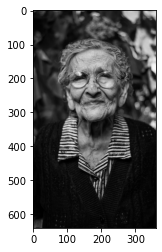

In [41]:
img_bgr = cv2.imread(new_img_path)
img = sticker_img_resize(img_bgr)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

number of faces : 1


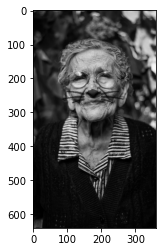

In [42]:
img_sticker = cat_whisker_sticker(img)
plt.imshow(img_sticker)
plt.show()

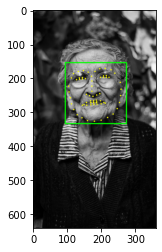

In [43]:
img_landmark = mark_landmarks(img)
plt.imshow(img_landmark)
plt.show()

+ works well with gray image

---

+ hair covering face
  + image source : https://unsplash.com/photos/qPKj1LSZQUY

In [44]:
new_img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image_06.jpg'

(640, 360, 3)


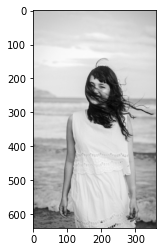

In [45]:
img_bgr = cv2.imread(new_img_path)
img = sticker_img_resize(img_bgr)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

number of faces : 0


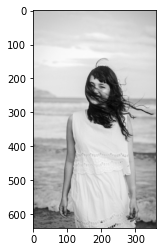

In [46]:
img_sticker = cat_whisker_sticker(img)
plt.imshow(img_sticker)
plt.show()

+ face detector did not recognize a face covered with hair.

---

+ group of people
  + image source : https://unsplash.com/photos/mZQpsI1CoVQ

In [47]:
new_img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image_07.jpg'

(360, 640, 3)


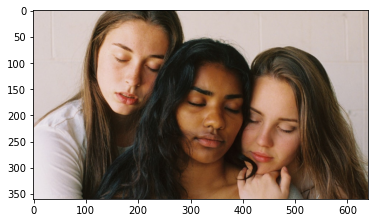

In [48]:
img_bgr = cv2.imread(new_img_path)
img = sticker_img_resize(img_bgr)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

number of faces : 3


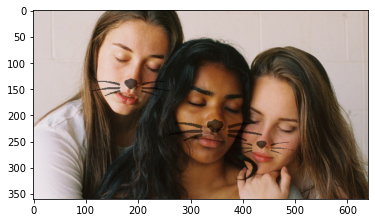

In [49]:
img_sticker = cat_whisker_sticker(img)
plt.imshow(img_sticker)
plt.show()

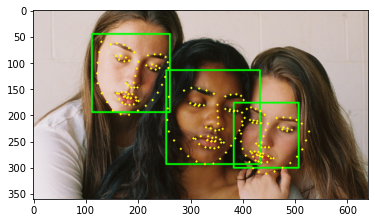

In [50]:
img_landmark = mark_landmarks(img)
plt.imshow(img_landmark)
plt.show()

+ whisker gets longer when face in the picture is tilted.
  + width of face detection box determines length of whiskers.
+ whisker sticker stays horizontal even with slanted faces.
  + need to rotate whisker image according to a angle calculated from landmark location ; height and width difference between eye-tail location seems promising.
    + need to learn how to rotate image by specific degree.
    + would rotating sticker image alter size of sticker image?
      + cannot imagine how to calculate sticker_area when stikcer image is rotated if image size stays the same after rotation.
+ need to learn how to inherit class from object created with cv2 imread function.
   + failed at attempt to make a class embraces defined above functions.; methods like 'shape' does not work at makeshift class, neither the functions.